# Visual search with KNN

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import os
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]= "-1" # Force Tensorflow on CPU instead of GPU (seems to avoid an error with my CUDA compatible GPU)

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load training data form NPZ file

train_data = "train.npz"
X_tr = np.load(train_data)["features"]
y_tr = np.load(train_data)["labels"]
images_tr = np.load(train_data)["pixels"]

valid_data = "valid.npz"
X_val= np.load(valid_data)["features"]
y_val = np.load(valid_data)["labels"]
images_val = np.load(valid_data)["pixels"]

test_data = "test.npz"
X_te= np.load(test_data)["features"]
y_te = np.load(test_data)["labels"]
images_te = np.load(test_data)["pixels"]

# Create a dictionnary for labels
labels_dict = {0: 'bike', 1 : 'car', 2: 'motorcycle', 3: 'other', 4:'truck', 5: 'van'}

In [3]:
pd.value_counts(y_tr, normalize=False)

0.0    66
1.0    64
2.0    51
4.0    42
3.0    32
5.0    25
dtype: int64

### Create KNN classifier

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:

# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors = 5, # Set k to 5
    algorithm='brute',
    metric = 'manhattan', # or euclidean (manhattan is usally better used when data is not standardized and have very different ranges : see MIT subject at 36 min https://www.youtube.com/watch?v=h0e2HAPTGF4&ab_channel=MITOpenCourseWare)
    weights = 'uniform' # or distance
)

# Create the pipeline and fit it to training data
knn_pipe = Pipeline([
    ('scaler', StandardScaler()), # With standardization works better here
    ('knn', knn)
])

knn_pipe.fit(X_tr, y_tr)

# Evaluate on val set
accuracy = knn_pipe.score(X_val, y_val)

# Print accuracy
print('k-nearest neighbors (k=5) accuracy: {:.3f}'.format(accuracy))

accuracy_test = knn_pipe.score(X_te, y_te)
# Print accuracy
print('k-nearest neighbors (k=5) accuracy: {:.3f}'.format(accuracy_test))

k-nearest neighbors (k=5) accuracy: 0.935
k-nearest neighbors (k=5) accuracy: 0.920


### Let's fine tune this classifier with a Grid Search
**To use Cross Validation, I will concatenate X_tr and X_val.**

In [6]:
X_gs_cv = np.concatenate((X_tr,X_val), axis=0, out=None)  # X for Cross Validation and Grid Search
y_gs_cv = np.concatenate((y_tr,y_val), axis=0, out=None) 

In [7]:
X_gs_cv.shape # (280 + 139 images) x 2048 features

(419, 2048)

In [8]:
y_gs_cv.shape # (280 + 139 labels)

(419,)

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
grid_params = {'knn__n_neighbors' : [3,5,11,19,29],
               'knn__metric' : ['euclidean','manhattan'],
               'knn__weights' : ['distance','uniform']}

In [11]:
gs = GridSearchCV(knn_pipe, grid_params, verbose = -1, cv = 8, n_jobs = -1, scoring='accuracy', refit = True) # use 8 cores

In [12]:
gs_results = gs.fit(X_gs_cv, y_gs_cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    9.8s finished
C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
print('Best Params :',gs_results.best_params_)
print('Best Score :',gs_results.best_score_)

Best Params : {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best Score : 0.9355608591885441


In [14]:
# Calculate accuracy with the best estimator with GridSearch Cross Validation
best_estimator = gs_results.best_estimator_
best_estimator.score(X_te,y_te)

0.92

### Checking KNN classifier score with these same parameters

In [15]:
### New Pipeline to check the best parameters
# Create k-NN classifier

knn3 = KNeighborsClassifier(
    n_neighbors=3, # Set k to 3 based on the best parameters
    algorithm='brute',
    metric = 'euclidean', # or manhattan (better use'Manhattan' when data is not standardized and have very different ranges : see MIT subject at 36 min https://www.youtube.com/watch?v=h0e2HAPTGF4&ab_channel=MITOpenCourseWare)
    weights = 'distance' # or uniform
)

# Create the pipeline and fit it to training data
knn3_pipe = Pipeline([
    ('scaler', StandardScaler()), # With standardization works better here
    ('knn3', knn3)
])

knn3_pipe.fit(X_gs_cv, y_gs_cv)

accuracy_test3 = knn3_pipe.score(X_te, y_te)

# Print accuracy
print('k-nearest neighbors (k=3) accuracy: {:.3f}'.format(accuracy_test3))

k-nearest neighbors (k=3) accuracy: 0.920


**Indeed I find the same results,** (however the result is slightly better when the pipeline is fit on the training set only)

I have to to use directly the KNN Classifier to use the kneighbors method. Then I have to scale.transform(X_te) instead of doing it in the Pipeline.

In [16]:

scaler = StandardScaler()
scaler.fit(X_gs_cv)
X_te_scaled = scaler.transform(X_te)

distance_10, neighbors_10 = knn3.kneighbors(X_te_scaled, n_neighbors = 10, return_distance = True)

In [17]:
print("neighbors",neighbors_10.shape)
print("distance",distance_10.shape)

neighbors (50, 10)
distance (50, 10)


### Let's create the concatenate the images_tr and images_valid to have the same size as X_gs_cv = X_tr + X_valid

In [18]:
images_full = np.concatenate((images_tr,images_val), axis=0, out=None)
images_full.shape

(419, 299, 299, 3)

Original Image Prediction: truck


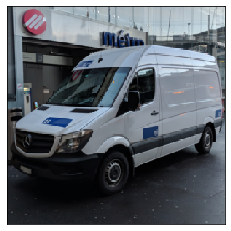

Neighbor n° 1
Distance 29.484367


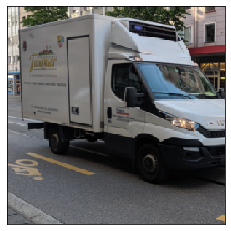

Neighbor n° 2
Distance 29.773556


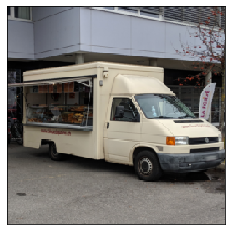

Neighbor n° 3
Distance 29.78347


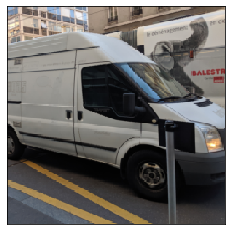

Neighbor n° 4
Distance 31.145023


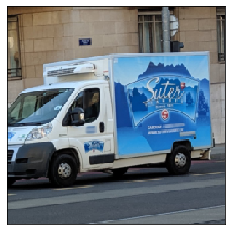

Neighbor n° 5
Distance 31.50994


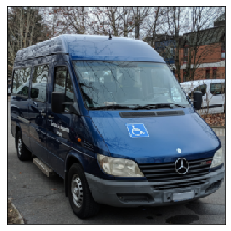

Neighbor n° 6
Distance 32.618774


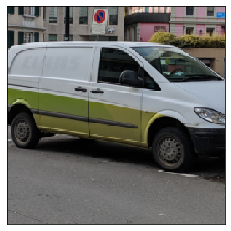

Neighbor n° 7
Distance 32.708202


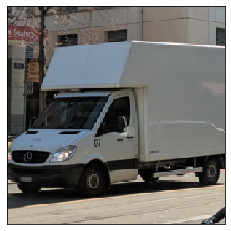

Neighbor n° 8
Distance 34.072613


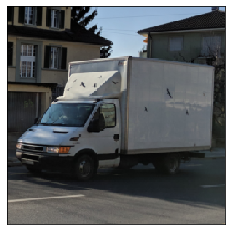

Neighbor n° 9
Distance 34.230587


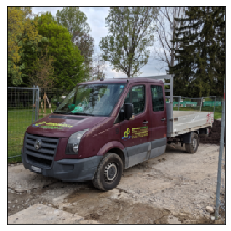

Neighbor n° 10
Distance 34.70053


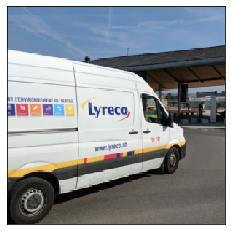

In [19]:
chosen_image = 49

# Plot image with pyplot
original_image = images_te[chosen_image]
fig = plt.imshow(original_image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# Predict label of original image
prediction = labels_dict[knn3_pipe.predict(X_te)[chosen_image]]# i use so pipeline so no need to use X_te_scaled (scaler directly in the pipeline)


print('Original Image Prediction:', prediction)
plt.show()

neigh_num = 0

for i in neighbors_10[chosen_image]:  #I chose one image randomly
    
    neighbor = images_full[i]    
    fig = plt.imshow(neighbor)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    print('Neighbor n°',neigh_num+1)
    print('Distance',distance_10[chosen_image][neigh_num])
    plt.show()
    
    neigh_num +=1
          


In [20]:
distance_10.min()

29.484367

In [27]:
import csv

header = ['model', 'test_accuracy']
data = ['KNN',accuracy_test3]


with open('Results.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)